<a href="https://colab.research.google.com/github/tbottelbergs/cv_copy/blob/master/CV_V0.0.11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer vision Final project

# Version History

## V0.0.1 
* One-hot encoding (based on first class)
* Predictions based on softmax (no extra hidden layer of MobileNetV2)
* Optimizer='rmsprop', Loss='categorical_crossentropy'

## V0.0.2
* Added extra hidden layer of 1024 nodes
* Accuracy never rises above 74% (depends on which class is selected as first class)

## V0.0.3
* Added multi-label targets
* Changed output layer to 'sigmoid' activation function
* Changed the loss function to tf.keras.losses.CategoricalCrossentropy(from_logits=True)
* Changed the metric to categorical_accuracy

## V0.0.4
* Changed loss function to tf.nn.sigmoid_cross_entropy_with_logits
-> doesn't make things better

## V0.0.5
* Using TruePositives, TrueNegatives, FalsePositives, FalseNegatives, TopKCategoricalAccuracy(k=1) as metric
* Added fine tuning of last 55 layers of the base model

## V0.0.6
* Split training and test as was done for the VOC dataset
* Removed from_logits = True
* Switched to BinaryCrossentropy instead of CategoricalCrossentropy
* Used Adam optimiser

## V0.0.7
* Using learning rate LR = 1e-5

## V0.0.8
* Doubled the number of epochs to 20
* Rescaled the data to [-1,1] -> did not seem to have a positive effect

## V0.0.9
* Added Macro F1 as a metric

## V0.0.10
* Increased learning rate to 1e-4 for the first learning part

## V0.0.11
* Added model training from scratch
* Added data augmentation
* Added inspection of the training data
* Added inspection of the model results

Fetch data

In [0]:
import os
from skimage import io
from skimage.transform import resize
import numpy as np
import random
import tensorflow as tf
from xml.dom import minidom
import matplotlib.pyplot as plt

In [2]:
!wget -nc http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar
!tar -xf VOCtrainval_11-May-2009.tar --totals



--2020-05-31 06:01:21--  http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 935534080 (892M) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2009.tar’

VOCtrainval_11-May- 100%[===================>] 892.19M  13.5MB/s    in 67s     

2020-05-31 06:02:29 (13.4 MB/s) - ‘VOCtrainval_11-May-2009.tar’ saved [935534080/935534080]

Total bytes read: 935536640 (893MiB, 342MiB/s)


To keep in mind:
* In one image, multiple objects can appear (also of different classes)
* Every image has at least one object in it?

In [0]:
voc_root_folder = "/content/VOCdevkit/VOC2009"
trainImageNamesFile = os.path.join(voc_root_folder,'ImageSets','Main','train.txt')
valImageNamesFile = os.path.join(voc_root_folder,'ImageSets','Main','val.txt')
trainImageNames = np.loadtxt(trainImageNamesFile, dtype='str')
valImageNames = np.loadtxt(valImageNamesFile, dtype='str')

In [4]:
CLASSES = ['aeroplane','bicycle','bird','boat','bottle', 'bus','car','cat','chair','cow', 'diningtable','dog','horse','motorbike','person','pottedplant','sheep','sofa','train','tvmonitor']
class_to_idx = dict((c, i) for i, c in enumerate(CLASSES))
idx_to_class = dict((i, c) for i, c in enumerate(CLASSES))
def one_hot_encode(clss):
  encoded = [0 for _ in range(len(CLASSES))]
  for cls in clss:
    encoded[class_to_idx[cls]] = 1
  return encoded
def one_hot_decode(encoded):
  clss = [idx_to_class[idx] for idx, val in enumerate(encoded) if val == 1]
  return clss
a = one_hot_encode(['bicycle', 'bus', 'chair'])
print(a)
print(one_hot_decode(a))

[0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['bicycle', 'bus', 'chair']


In [0]:
image_folder = os.path.join(voc_root_folder, "JPEGImages")
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

def createDataSet(imageNames):
  images = []
  targets = []
  for imageName in imageNames:
    xmlFile = os.path.join(voc_root_folder,'Annotations',imageName + '.xml')
    xml = minidom.parse(xmlFile)
    objectsXml = xml.getElementsByTagName('object')
    objects = []
    image = io.imread(os.path.join(image_folder,imageName + ".jpg"))
    image = (image/127.5) - 1
    #image = image/255
    image = resize(image, IMG_SHAPE)
    for objectXml in objectsXml:
      object = objectXml.getElementsByTagName('name')[0].firstChild.nodeValue
      if object not in objects:
        objects.append(object)
    #if(len(objects) == 1):
    targets.append(one_hot_encode(objects))
    images.append(image)
  return (images,targets)

In [0]:
trainImages, trainTargets = createDataSet(trainImageNames)
validationImages, validationTargets = createDataSet(valImageNames)

min: -0.9999887943267822
max: 0.9996830224990845
min: -0.8675720244646072
max: 0.9999784231185913
min: -0.999987905845046
max: 0.999993085861206
min: -0.9992042779922485
max: 0.9999994039535522
min: -0.9649058729410172
max: 0.744956374168396


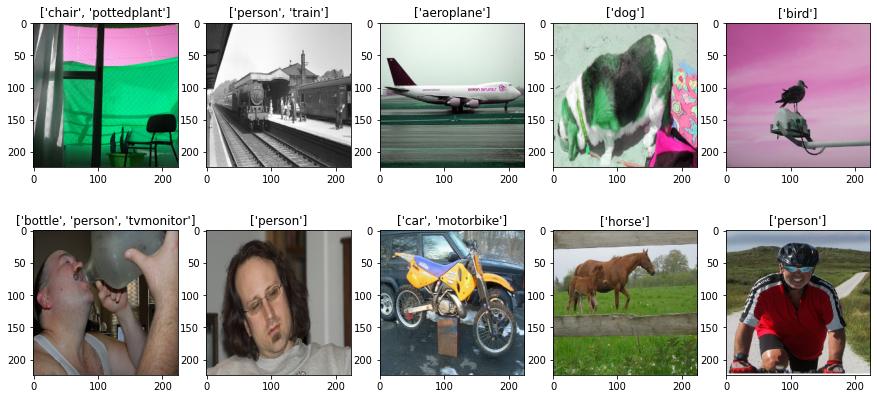

In [67]:
fig=plt.figure(figsize=(15, 7))
for i in range(1,6):
  idx = random.randint(0,len(trainImages))
  fig.add_subplot(2, 5, i)
  plt.imshow((augment(trainImages[idx], 'a')[0] + 1)/2)
  plt.title(one_hot_decode(trainTargets[idx]))
for i in range(6,11):
  idx = random.randint(0,len(validationImages))
  fig.add_subplot(2, 5, i)
  plt.imshow((validationImages[idx]+1)/2)
  plt.title(one_hot_decode(validationTargets[idx]))

The images often have a different aspect ratio then (224,224), but we need this shape for the CNN we are going to use further on. This is why some of the images seem a little bit 'squeezed'.
The CNN networks that will be used later on, require the input to be in the range [-1,1]

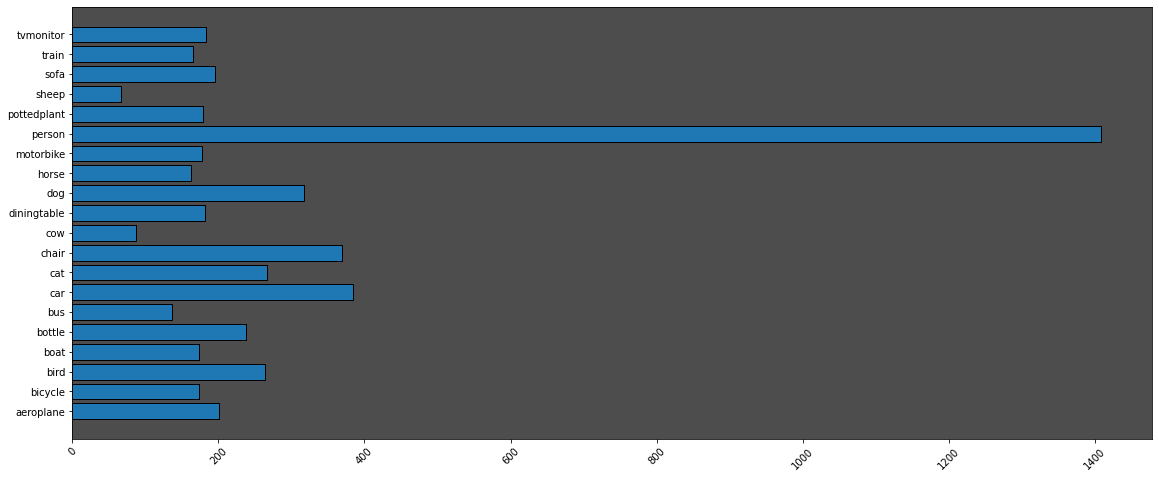

In [8]:
targetArray = np.array(trainTargets)
targetSum = np.sum(targetArray, axis=0)
fig = plt.figure(figsize=(15, 6))
ax = fig.add_axes([0,0,1,1])
ax.barh(CLASSES, targetSum, linewidth=1, edgecolor='k')
ax.set_facecolor('0.3')
plt.xticks(rotation = 45)
plt.show()

We see that the category 'Person' is overrepresented in the dataset, which will influence the learning later on.

In [0]:
x_train = np.array(trainImages).astype('float32')
y_train = np.array(trainTargets)
x_val = np.array(validationImages).astype('float32')
y_val = np.array(validationTargets)

In [0]:
def augment(image,label):
  image = (image+1)/2
  #image = tf.image.adjust_hue(image, 0.3)
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_contrast(image, 0.2, 0.5)
  image = tf.image.random_brightness(image, max_delta=0.5) 
  image = image * 2 - 1
  #print('min: ' + str(np.min(image)))
  #print('max: ' + str(np.max(image)))
  return image,label

In [0]:
BATCH_SIZE = 100
train_batches = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(augment).shuffle(len(x_train)//2).batch(BATCH_SIZE)
validation_batches = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)

In [117]:
len(x_train)

3473

In [133]:
augmented_train_batches = train_batches.concatenate(train_batches.map(augment)).shuffle(len(x_train)//2).unbatch().batch(BATCH_SIZE)

test


In [129]:
augmented_train_batches

<BatchDataset shapes: ((None, 224, 224, 3), (None, 20)), types: (tf.float32, tf.int64)>

In [86]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [0]:
base_model.trainable = False

For the first model (the CNN trained from scratch), we will use a much simpler architecture then the one we will use for transfer learning later on. This is because we have a limited amount of data available, so we want to limit the complexity and the number of parameters in the model.
For this model we will use a series of convulution and maxpooling layers. Our input shape is (224,224,3).
We end with a dense layer with 20 nodes, that will represent the 20 classes we want to predict. We are using a 'sigmoid' activiation function, because we want a separate prediction for each class for every image (we are doing multilabel classification) opposed to using a softmax layer were we only want to predict 1 label per image.

In [0]:
model2 = tf.keras.models.Sequential()
model2.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(224, 224, 3)))
model2.add(tf.keras.layers.MaxPooling2D((2, 2)))
model2.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model2.add(tf.keras.layers.MaxPooling2D((2, 2)))
model2.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model2.add(tf.keras.layers.MaxPooling2D((2, 2)))
model2.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model2.add(tf.keras.layers.MaxPooling2D((2, 2)))
model2.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model2.add(tf.keras.layers.Flatten())
tf.keras.layers.Dropout(0.2)
model2.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model2.add(tf.keras.layers.Dense(20, activation='sigmoid'))

In [95]:
model2.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 52, 52, 64)        36928     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 24, 24, 64)      

In [0]:
#base_model.layers[4].activation

In [0]:
#base_model.summary()

In [0]:
class MacroF1(tf.keras.metrics.Metric):

    def __init__(self, name='macro_f1', **kwargs):
      super(MacroF1, self).__init__(name=name, **kwargs)
      self.true_positives = self.add_weight(name='tp', shape=(20), initializer='zeros')
      self.false_positives = self.add_weight(name='fp', shape=(20), initializer='zeros')
      self.true_negatives = self.add_weight(name='tn', shape=(20), initializer='zeros')
      self.false_negatives = self.add_weight(name='fn', shape=(20), initializer='zeros')
      self.f1 = self.add_weight(name='f1', shape=(20), initializer='zeros')

    def update_state(self, y_true, y_pred):
      y_pred = tf.cast(tf.greater(y_pred, 0.5), tf.float32)
      tp = tf.cast(tf.math.count_nonzero(y_pred * y_true, axis=0), tf.float32)
      fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y_true), axis=0), tf.float32)
      tn = tf.cast(tf.math.count_nonzero((1 - y_pred) * (1 - y_true), axis=0), tf.float32)
      fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y_true, axis=0), tf.float32)
      self.true_positives.assign_add(tp)
      self.false_positives.assign_add(fp)
      self.true_negatives.assign_add(tn)
      self.false_negatives.assign_add(fn)

    def result(self):
      f1 = 2*self.true_positives / (2*self.true_positives + self.false_negatives + self.false_positives + 1e-16)
      self.f1.assign(f1)
      macro_f1 = tf.reduce_mean(f1)
      return macro_f1

    def reset_states(self):
      # The state of the metric will be reset at the start of each epoch.
      self.true_positives.assign(np.zeros(20))
      self.false_positives.assign(np.zeros(20))
      self.true_negatives.assign(np.zeros(20))
      self.false_negatives.assign(np.zeros(20))
      self.f1.assign(np.zeros(20))

In [0]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
predictions = tf.keras.layers.Dense(20, activation='sigmoid')
LR = 1e-4
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  tf.keras.layers.Dense(1024, activation='relu', name='hidden_layer'),
  predictions
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss=tf.keras.losses.BinaryCrossentropy(), metrics=[MacroF1(), tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.TopKCategoricalAccuracy(k=1)])

In [0]:
base_model2 = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights=None)
LR = 1e-4
model2 = tf.keras.Sequential([
  base_model2,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(1024, activation='relu', name='hidden_layer'),
  tf.keras.layers.Dense(20, activation='sigmoid')
])
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss=tf.keras.losses.BinaryCrossentropy(), metrics=[MacroF1(), tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.TopKCategoricalAccuracy(k=1)])

In [0]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss=tf.keras.losses.BinaryCrossentropy(), metrics=[MacroF1(), tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.TopKCategoricalAccuracy(k=1)])

The binary crossentropy loss is used, since there are a number of output that each predict true/false for that specific label. If there would be only 1 label for each input, 'CategoricalCrossentropy' could have been used.

In [83]:
epochCount = 120
history = model2.fit(train_batches,
                    epochs=epochCount,
                    validation_data=validation_batches)

Epoch 1/40
35/35 [==============================] - 10s 276ms/step - loss: 0.1418 - macro_f1: 0.5098 - true_positives_4: 2468.0000 - true_negatives_4: 63559.0000 - false_positives_4: 573.0000 - false_negatives_4: 2860.0000 - top_k_categorical_accuracy: 0.5053 - val_loss: 0.4578 - val_macro_f1: 0.2183 - val_true_positives_4: 1427.0000 - val_true_negatives_4: 63631.0000 - val_false_positives_4: 2605.0000 - val_false_negatives_4: 3957.0000 - val_top_k_categorical_accuracy: 0.2295
Epoch 2/40
35/35 [==============================] - 10s 279ms/step - loss: 0.1402 - macro_f1: 0.5210 - true_positives_4: 2495.0000 - true_negatives_4: 63594.0000 - false_positives_4: 538.0000 - false_negatives_4: 2833.0000 - top_k_categorical_accuracy: 0.5065 - val_loss: 0.4535 - val_macro_f1: 0.2264 - val_true_positives_4: 1701.0000 - val_true_negatives_4: 63226.0000 - val_false_positives_4: 3010.0000 - val_false_negatives_4: 3683.0000 - val_top_k_categorical_accuracy: 0.2438
Epoch 3/40
35/35 [==================

KeyboardInterrupt: ignored

In [133]:
print(len(base_model.layers))

155


In [134]:
print(sum(sum(y_train)))
print(y_train.shape)

5328
(3473, 20)


In [89]:
epochCount = 20
history = model.fit(train_batches,
                    epochs=epochCount,
                    validation_data=validation_batches)

Epoch 1/20
35/35 [==============================] - 12s 345ms/step - loss: 0.3098 - macro_f1: 0.0534 - true_positives_5: 680.0000 - true_negatives_5: 61253.0000 - false_positives_5: 2879.0000 - false_negatives_5: 4648.0000 - top_k_categorical_accuracy: 0.1342 - val_loss: 0.2152 - val_macro_f1: 0.0501 - val_true_positives_5: 1058.0000 - val_true_negatives_5: 65872.0000 - val_false_positives_5: 364.0000 - val_false_negatives_5: 4326.0000 - val_top_k_categorical_accuracy: 0.2335
Epoch 2/20
35/35 [==============================] - 11s 308ms/step - loss: 0.1900 - macro_f1: 0.1630 - true_positives_5: 1343.0000 - true_negatives_5: 63920.0000 - false_positives_5: 212.0000 - false_negatives_5: 3985.0000 - top_k_categorical_accuracy: 0.3665 - val_loss: 0.1658 - val_macro_f1: 0.2611 - val_true_positives_5: 1761.0000 - val_true_negatives_5: 66073.0000 - val_false_positives_5: 163.0000 - val_false_negatives_5: 3623.0000 - val_top_k_categorical_accuracy: 0.4879
Epoch 3/20
35/35 [====================

In [0]:
#history.history

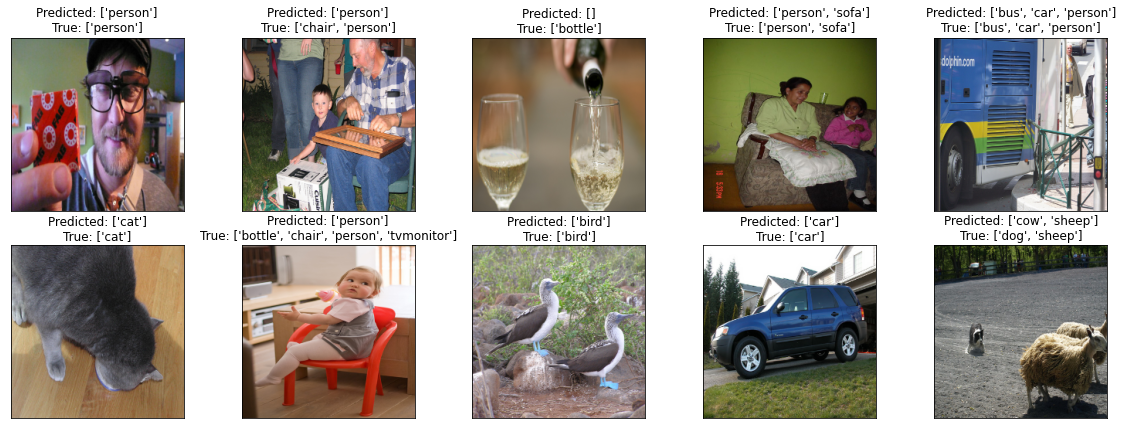

In [90]:
fig=plt.figure(figsize=(20, 7))
for i in range(1,6):
  idx = random.randint(0,len(x_train))
  fig.add_subplot(2, 5, i)
  plt.imshow((x_train[idx]+1)/2)
  y_pred = one_hot_decode(np.around(model(x_train[idx:idx+1])[0]).astype('int'))
  plt.title('Predicted: {}\nTrue: {}'.format(y_pred, one_hot_decode(y_train[idx])))
  plt.xticks([])
  plt.yticks([])
for i in range(6,11):
  idx = random.randint(0,len(x_val))
  fig.add_subplot(2, 5, i)
  plt.imshow((x_val[idx]+1)/2)
  y_pred = one_hot_decode(np.around(model(x_val[idx:idx+1])[0]).astype('int'))
  plt.title('Predicted: {}\nTrue: {}'.format(y_pred, one_hot_decode(y_val[idx])))
  plt.xticks([])
  plt.yticks([])

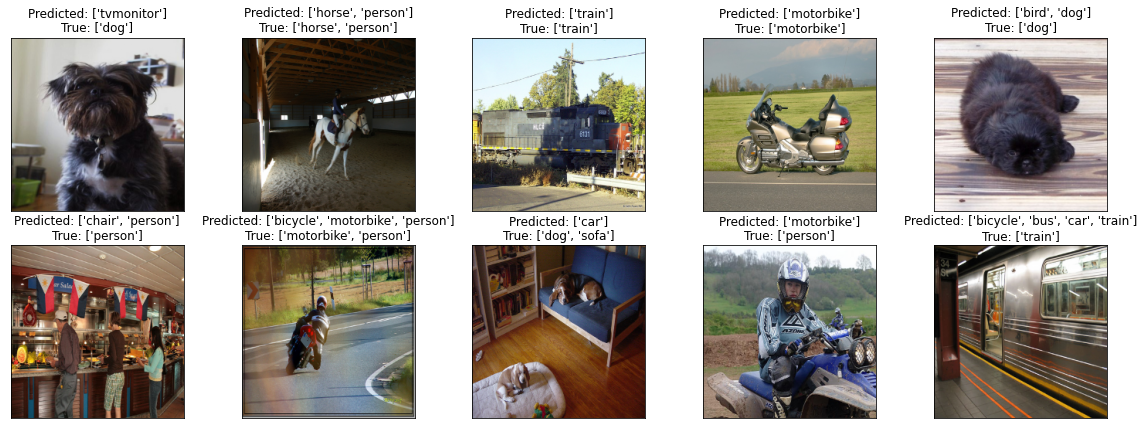

In [85]:
fig=plt.figure(figsize=(20, 7))
for i in range(1,6):
  idx = random.randint(0,len(x_train))
  fig.add_subplot(2, 5, i)
  plt.imshow((x_train[idx]+1)/2)
  y_pred = one_hot_decode(np.around(model2(x_train[idx:idx+1])[0]).astype('int'))
  plt.title('Predicted: {}\nTrue: {}'.format(y_pred, one_hot_decode(y_train[idx])))
  plt.xticks([])
  plt.yticks([])
for i in range(6,11):
  idx = random.randint(0,len(x_val))
  fig.add_subplot(2, 5, i)
  plt.imshow((x_val[idx]+1)/2)
  y_pred = one_hot_decode(np.around(model2(x_val[idx:idx+1])[0]).astype('int'))
  plt.title('Predicted: {}\nTrue: {}'.format(y_pred, one_hot_decode(y_val[idx])))
  plt.xticks([])
  plt.yticks([])

In [0]:
base_model.trainable = True
for layer in base_model.layers[:80]:
  layer.trainable =  False

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR/10), loss=tf.keras.losses.BinaryCrossentropy(), metrics=[MacroF1(), tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.TopKCategoricalAccuracy(k=1)])

In [97]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
hidden_layer (Dense)         (None, 1024)              1311744   
_________________________________________________________________
dense_10 (Dense)             (None, 20)                20500     
Total params: 3,590,228
Trainable params: 3,371,156
Non-trainable params: 219,072
_________________________________________________________________


In [98]:
epochCount = 15
history = model.fit(train_batches,
                    epochs=epochCount,
                    validation_data=validation_batches)

Epoch 1/15
35/35 [==============================] - 13s 377ms/step - loss: 0.0587 - macro_f1: 0.8313 - true_positives_7: 4182.0000 - true_negatives_7: 63811.0000 - false_positives_7: 321.0000 - false_negatives_7: 1146.0000 - top_k_categorical_accuracy: 0.7204 - val_loss: 0.0889 - val_macro_f1: 0.7504 - val_true_positives_7: 3821.0000 - val_true_negatives_7: 65688.0000 - val_false_positives_7: 548.0000 - val_false_negatives_7: 1563.0000 - val_top_k_categorical_accuracy: 0.6965
Epoch 2/15
35/35 [==============================] - 12s 340ms/step - loss: 0.0553 - macro_f1: 0.8431 - true_positives_7: 4238.0000 - true_negatives_7: 63847.0000 - false_positives_7: 285.0000 - false_negatives_7: 1090.0000 - top_k_categorical_accuracy: 0.7345 - val_loss: 0.0890 - val_macro_f1: 0.7516 - val_true_positives_7: 3823.0000 - val_true_negatives_7: 65704.0000 - val_false_positives_7: 532.0000 - val_false_negatives_7: 1561.0000 - val_top_k_categorical_accuracy: 0.6937
Epoch 3/15
35/35 [====================

* categorical_accuracy: the node with the highest output should also be a detected label
* sigmoid_cross_entropy_with_logits

In [0]:
model.save('transfer_learning_model.h5')
model2.save('from_scratch_model.h5')

In [0]:
base_model.summary()

In [142]:
m = tf.keras.metrics.CategoricalAccuracy() 
_ = m.update_state([[0,0,1,0],[0, 1, 0, 0]], [[0,0.1,0.1,0.2],[0, 1, 0, 0]]) 
m.result().numpy() 

0.5

In [143]:
m = tf.keras.metrics.TopKCategoricalAccuracy(k=1)
_ = m.update_state([[0,0,1,1],[0, 1, 0, 0]], [[0,0.6,0.5,0.2],[0, 1, 0, 0]]) 
m.result().numpy() 

0.5

In [144]:
print(x_val[0:1].shape)

(1, 224, 224, 3)


In [51]:
y_pred = model(x_val[0:1])
y_pred = np.around(y_pred).astype('int')
print(y_pred)
print(one_hot_decode(y_pred[0]))
print(one_hot_decode(y_val[0]))

[[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]]
['chair']
['tvmonitor']


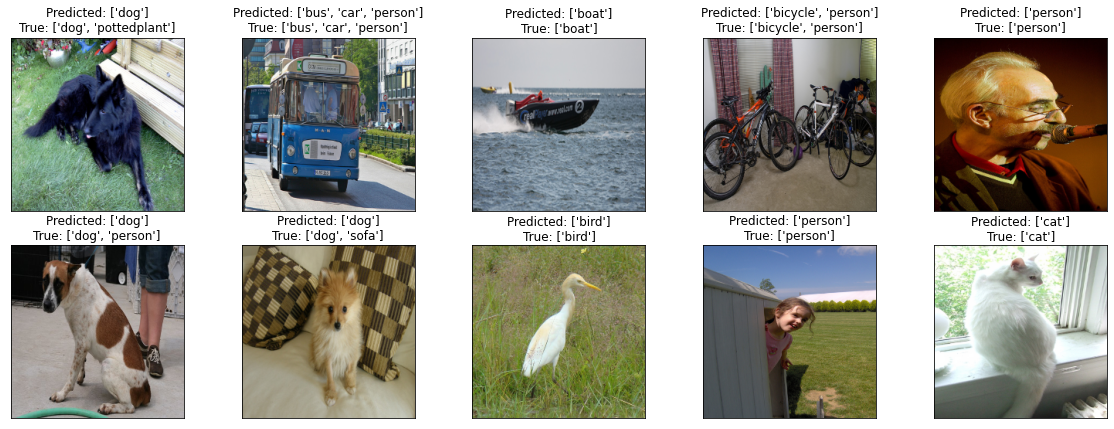

In [148]:
fig=plt.figure(figsize=(20, 7))
for i in range(1,6):
  idx = random.randint(0,len(x_train))
  fig.add_subplot(2, 5, i)
  plt.imshow((x_train[idx]+1)/2)
  y_pred = one_hot_decode(np.around(model(x_train[idx:idx+1])[0]).astype('int'))
  plt.title('Predicted: {}\nTrue: {}'.format(y_pred, one_hot_decode(y_train[idx])))
  plt.xticks([])
  plt.yticks([])
for i in range(6,11):
  idx = random.randint(0,len(x_val))
  fig.add_subplot(2, 5, i)
  plt.imshow((x_val[idx]+1)/2)
  y_pred = one_hot_decode(np.around(model(x_val[idx:idx+1])[0]).astype('int'))
  plt.title('Predicted: {}\nTrue: {}'.format(y_pred, one_hot_decode(y_val[idx])))
  plt.xticks([])
  plt.yticks([])

Some confusion occurs in the algorithm because we are doing multilabel classification instead of detection. The algorithm seems to get confused sometimes because it does not always find the exact area in the picture to which the label belongs. Tipical cases are predicting a person and a bike, when only a bike is visible in the picture, probably because in most pictures these occur together, which might confuse the alogritm. Similarly, a bottle seems to be hard to predict. Probably, because this mostly is a small part of a picture, surrounded by different other objects.

In [0]:
result = model.predict(validation_batches)

In [0]:
y_pred = tf.cast(tf.greater(result, 0.5), tf.float32)
tp = tf.cast(tf.math.count_nonzero(y_pred * y_val, axis=0), tf.float32)
fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y_val), axis=0), tf.float32)
tn = tf.cast(tf.math.count_nonzero((1 - y_pred) * (1 - y_val), axis=0), tf.float32)
fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y_val, axis=0), tf.float32)
f1 = 2* tp / (2 * tp + fn + fp + 1e-16)

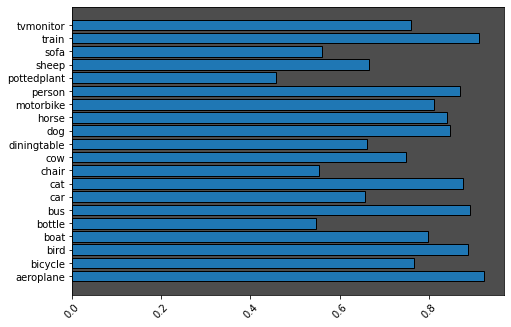

In [124]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.barh(CLASSES, f1, linewidth=1, edgecolor='k')
ax.set_facecolor('0.3')
plt.xticks(rotation = 45)
plt.show()

It is easy to get good result for person, since that often occurs in the images.
There is a good F1 score for aeroplanes, which seems explainable because there are quite some aeroplanes in the dataset and they often occur alone in an image. Making them easier to train and easier to recognize.
Potted plants perform the worst, probably because they have a wide variety of appearances, often occur together with other objects in the image (and are often the smaller ones) and don't occur in the training set a lot.
Bottles have similar problems to be recognized, but have a more recognizable appearance, so have a slightly better score.
Chairs and sofas often occur together with other object in the image, but are also often occluded by those other objects.

In [0]:
lonely_y = y_train[np.sum(y_train, axis=1) == 1]

In [145]:
np.sum(y_train)

5328

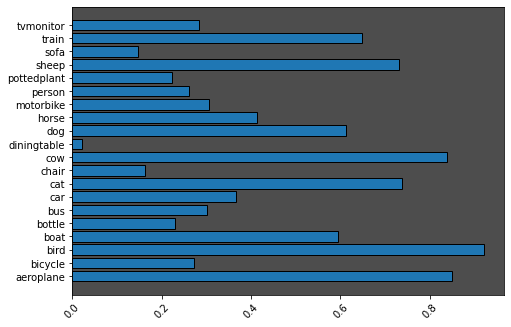

In [147]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.barh(CLASSES, sum(lonely_y) / sum(y_train), linewidth=1, edgecolor='k')
ax.set_facecolor('0.3')
plt.xticks(rotation = 45)
plt.show()

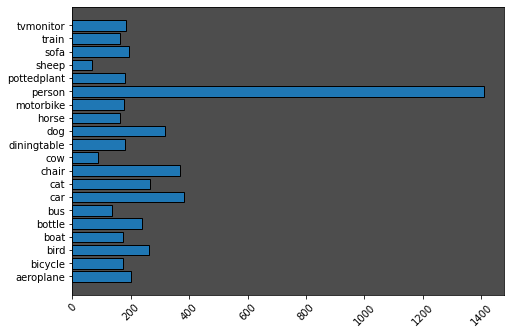

In [143]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.barh(CLASSES, sum(y_train), linewidth=1, edgecolor='k')
ax.set_facecolor('0.3')
plt.xticks(rotation = 45)
plt.show()

In [0]:
result2 = model2.predict(validation_batches)

In [0]:
y_pred2 = tf.cast(tf.greater(result2, 0.5), tf.float32)
tp2 = tf.cast(tf.math.count_nonzero(y_pred2 * y_val, axis=0), tf.float32)
fp2 = tf.cast(tf.math.count_nonzero(y_pred2 * (1 - y_val), axis=0), tf.float32)
tn2 = tf.cast(tf.math.count_nonzero((1 - y_pred2) * (1 - y_val), axis=0), tf.float32)
fn2 = tf.cast(tf.math.count_nonzero((1 - y_pred2) * y_val, axis=0), tf.float32)
f12 = 2* tp2 / (2 * tp2 + fn2 + fp2 + 1e-16)

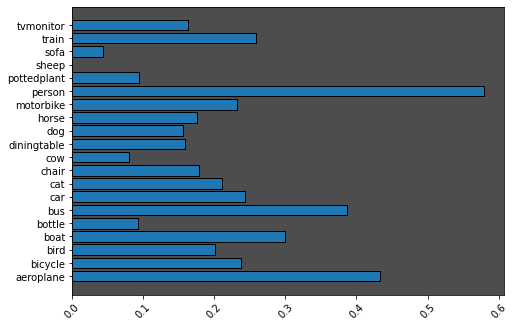

In [127]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.barh(CLASSES, f12, linewidth=1, edgecolor='k')
ax.set_facecolor('0.3')
plt.xticks(rotation = 45)
plt.show()